# Accretion disk

The file `Bobrikova_compton_slab_I.npz`, which contains the atmosphere data for an accretion powered hot spot, is required for this tutorial to run as intended. Still, in principle one could use any atmosphere, such as a default blackbody atmosphere, which does not require this file.

In this tutorial we will set up an accretion disk, which is a radiation source separate from the star, and add its contribution to the signal. If you don't want an explanation but just a working example of a star with an accretion disk in X-PSI, you can find it in `/examples/example_modelling_tutorial/TestRun_AMXP.py`. From there you can copy the code and modify it as you wish. 

The accretion disk we will use here ([Mitsuda et al. 1984](https://ui.adsabs.harvard.edu/abs/1984PASJ...36..741M/abstract), [Makishima et al. 1986](https://ui.adsabs.harvard.edu/abs/1986ApJ...308..635M/abstract)) is a superposition of multicolor blackbody rings. It does not include relativistic effects and spectral hardening.

## Setting up the disk model

We follow here the description given by Makishima et al. (1986). The disk is parametrized by an inner cut-off radius, $R_\rm{in}$, a temperature at this radius, $T_\rm{in}$, and an outer radius, $R_\rm{out}$. The outer rings will contribute much less to the X-ray spectrum than inner rings due to being much colder, so the exact value of $R_\rm{out}$ is much less consequential than $R_\rm{in}$. For each ring, the temperature at some radius $T(r)$ is determined by the (gravitational) energy release associated with accretion towards a central object of mass $M_*$. It is expressed as:

$$T(r) = \left(\frac{3 G \dot{M} M_*}{8 \pi \sigma r^3}\right)^{1/4},$$

where $G$ is the gravitational constant, $\dot{M}$ is the accretion rate and $\sigma$ is the Stefan-Boltzmann constant. If the accretion and the luminosity from accretion were isotropic, one could thus infer accretion rate if all the other parameters in this equation were known. However, this will not be the case (i.e. not isotropic) in the situations we will be considering so we can not apply this equation for that purpose and we will not be using it at all in the end. Nevertheless, we included it here as it is relevant context for how the temperature is produced and how it is distributed (even if just approximately) in the radial direction.

The surface area $dA$ of an infinitesimal ring between between $r-dr$ and $r$ is given by $2 \pi r dr$. The specific luminosity $dL_\rm{ring}(E)$ (energy/time/energy) of two hemispheres becomes

$$dL_\rm{ring}(E) = 4 B(E,T(r)) dA \int d\Omega= 8 \pi B(E,T(r)) r dr \int d\Omega = 8 \pi^2 B(E,T(r)) r dr.$$ 

Here the integral of the solid angle over one hemisphere evaluates to $\pi$. We multiply by 2 for the two sides of the disk and another factor of 2 appears since we define the $B(E, T)$, as half of the blackbody spectral radiance,  

$$B(E,T) = \frac{E^3}{c^2h^2}\left[\exp{\left(\frac{E}{k_\rm{B}T}\right)-1}\right]^{-1}. $$

Next up, we will provide the python functions involved in computing the radiation from the accretion disk that we will later collect into a python class. Let's start with the definition of $B(E, T)$:

In [1]:
import numpy as np
from xpsi.global_imports import  _keV, _k_B, _h_keV
_c = 2.99792458E8
_c_cgs = _c*1E2

def B_E(self, E, T):
    '''
    Half the energy radiance of a blackbody. If the the photon energy is much higher than kT, 
    the radiance is set to zero and ignores a warning.

    parameters:
        E in keV
        T in keV

    returns:
        B_E in keV/s/keV/cm^2/sr (you will integrate over keV)
    '''
    with np.errstate(over='ignore'):
        safe_ET = np.float128(E / T)
        exp_safe_ET = np.exp(safe_ET)
    B = np.where(np.isinf(exp_safe_ET), 0, E**3 / (_h_keV**3 * _c_cgs**2) / (exp_safe_ET - 1))
    return B

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 3.0.4               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Check your emcee installation.
Check your installation of emcee if using the EnsembleSampler
Imported PyMultiNest.
Check your UltraNest installation.
Check your installation of UltraNest if using the UltranestSampler
Imported GetDist version: 1.5.3
Imported nestcheck version: 0.2.1


The specific flux of the disk $f_\rm{disk}(E)$ (energy/time/length$^2$/energy) is the integral of the contribution of each ring from $R_\rm{in}$ to $R_\rm{out}$. This can be conveniently expressed as an integral over $dT$:


\begin{equation}
\begin{aligned}
f_\mathrm{disk}(E) &= \frac{\cos{i} \int dL_\mathrm{ring}}{4\pi D^2} \\
&= \frac{2 \pi \cos{i}}{D^2} \int_{R_\mathrm{in}}^{R_\mathrm{out}} r B(E,T(r)) \, dr \\
&= \frac{8\pi R_\mathrm{in}^2 \cos{i}}{3 D^2 T_\mathrm{in}} 
\int_{T_\mathrm{out}}^{T_\mathrm{in}} \Big(\frac{T}{T_\mathrm{in}}\Big)^{-11/3} B(E,T) \, dT.
\end{aligned}
\end{equation}

Where $D$ is the distance and we introduced $\cos{i}$ to scale the flux to account for the viewing angle.

In the code, similar to the approach in Xspec (the diskbb model), we collect the three parameters outside of the integral into a normalisation factor 
$$K_\rm{disk} = R_\rm{in}^2 \cos{i} / D^2.$$ 

In [2]:
def get_k_disk(cos_i, r_in, distance):
    """
    This function calculates the k-disk value for a given set of input parameters.
    
    Parameters
    ----------
    cos_i: The cosine inclination angle of the disk
    r_in: The inner radius of the disk in kilometers
    distance: The distance to the disk (and star) in kiloparsecs
    
    Returns
    -------
    k_disk normalisation factor
    
    """

    k_disk = cos_i * (r_in / (distance / 10))**2 # in [km/ 10 kpc]^2
    
    # K_disk is cos_i*R_in^2/D^2 in (km / 10 kpc)^2.
    # (1 km / 10 kpc)^2 = 1.0502650e-35 [ cm/cm ]^2

    k_disk *= 1.0502650e-35 # now k_disk is unitless

    return k_disk

We also define the integrand $l_\rm{disk}(E,T) = \frac{1}{T_\rm{in}}(\frac{T}{T_\rm{in}})^{-11/3}B(E,T)$.

In [3]:
from scipy.integrate import quad

def l_disk_integrand(self, T, E, T_in, spectral_radiance):
    '''
    parameters:
        T, T_in in keV
        E in keV

    returns:
        integrand in spectral radiance units/keV. This integrand will 
        be integrated over keV.
    '''

    integrand = (T/T_in)**(-11/3)*spectral_radiance(E, T)/T_in
    return integrand

def l_disk_integrated(self, E, T_in, T_out, spectral_radiance, epsrel):
    '''
    parameters:
        T, T_in in keV
        E in keV

    returns:
        disk luminosity [spectral radiance units]. 
    '''

    integrated,_= quad(self.l_disk_integrand, T_out, T_in, args=(E, T_in, spectral_radiance), epsrel=epsrel)
    return integrated

For clarity let's rewrite $f_\rm{disk}$ in the way it is used in the code:

$$f_\rm{disk}(E) = \frac{8 \pi}{3} K_\rm{disk} \int_{T_\rm{out}}^{T_\rm{in}} l_\rm{disk}(E,T) dT$$

In [4]:
k_B_over_keV = _k_B / _keV

def get_f_disk(self, energies, spectral_radiance):
    """ Evaluate f_disk(E). This function also requires the X-PSI parameters T_in and K_disk to be defined.
    
    Parameters
    ----------
    energies[keV]
    
    Returns
    -------
    f_disk [keV/s/cm^2/keV]
    
    """
    
    T_in = self['T_in'] # in 10^T K
    K_disk = self['K_disk'] # 

    T_in_keV = k_B_over_keV * pow(10.0, T_in)       
    T_out_keV = T_in_keV*1e-1 # hardcode a factor 10 difference
    
    epsrel = 1e-4 # hardcode precision for integration

    f_disk_array = np.array([])
    for energy in energies:
        f_disk_value = self.l_disk_integrated(energy, T_in_keV, T_out_keV, spectral_radiance, epsrel) 
        f_disk_array=np.append(f_disk_array,f_disk_value)
    
    f_disk_array *=K_disk*8*np.pi/3 # keV/s/cm^2/keV
    
    return f_disk_array

To obtain the photon flux for the disk instead of energy flux, one can divide $f_\rm{disk}(E)$ by the photon energy. Let's collect these function into an X-PSI compatible class. With initiation of an instance of the class, we initiate the three X-PSI compatible parameters that control the accretion disk. When one calls the instance with an array of energies, photon flux at each energy is returned. 

In [5]:
from xpsi.ParameterSubspace import ParameterSubspace
from xpsi.Parameter import Parameter, Derive

class Disk(ParameterSubspace):
    """
    A class representing an accretion disk model compatible with the X-PSI framework.

    This class initializes and manages three X-PSI-compatible parameters that describe 
    the physical properties of an accretion disk: the inner disk temperature, the inner 
    disk radius, and the disk normalization. Once instantiated, the class allows for 
    the computation of the photon flux at specified energy values.

    Parameters
    ----------
    bounds : dict, optional
        A dictionary specifying bounds for each parameter. Keys must include:
        - 'T_in': Bounds for the logarithm (base 10) of the inner disk temperature in Kelvin.
        - 'R_in': Bounds for the inner disk radius in kilometers.
        - 'K_disk': Bounds for the disk normalization.
        Default is None, which uses the strict bounds defined in the Parameter objects.
    
    values : dict, optional
        A dictionary specifying initial values for each parameter. Keys must include:
        - 'T_in': Initial value for the logarithm (base 10) of the inner disk temperature in Kelvin.
        - 'R_in': Initial value for the inner disk radius in kilometers.
        - 'K_disk': Initial value for the disk normalization.
        Default is None, which sets no initial values.

    Methods
    -------
    __call__(energies):
        Computes and returns the photon flux in photons/s/cm^2/keV for the given array of energy
        values in keV.

    Attributes
    ----------
    inner_temperature : Parameter
        The parameter representing the logarithm of the inner disk temperature in Kelvin.
    inner_radius : Parameter
        The parameter representing the inner disk radius in kilometers.
    background_normalisation : Parameter
        The parameter representing the disk normalization factor.
    disk_flux : ndarray
        The computed photon flux as a function of energy after calling the instance.

    Notes
    -----
    - The `Disk` class is designed for compatibility with the X-PSI (X-ray spectral 
      fitting) framework, and the parameters follow X-PSI conventions.
    - The photon flux is computed based on the provided energy array using the 
      Planck function, with scaling determined by the disk's physical parameters.
    - The call function requires the functions B_E and get_f_disk which have been 
      defined above in this tutorial.

    Example
    -------
    >>> bounds = {'T_in': (3., 10.), 'R_in': (0., 1e3), 'K_disk': (0., 1e100)}
    >>> values = {'T_in': 6.5, 'R_in': 10., 'K_disk': 1e2}
    >>> disk = Disk(bounds=bounds, values=values)
    >>> energies = np.linspace(1, 10, 100)  # Example energy array
    >>> flux = disk(energies)
    >>> print(flux)
    """
    
    def __init__(self, bounds=None, values=None):

        doc = """
        Temperature at inner disk radius in log10 Kelvin.
        """
        inner_temperature = Parameter('T_in',
                                strict_bounds = (3., 10.),
                                bounds = bounds.get('T_in', None),
                                doc = doc,
                                symbol = r'$T_{in}$',
                                value = values.get('T_in', None))

        doc = """
        Disk R_in in kilometers.
        """
        inner_radius = Parameter('R_in',
                                strict_bounds = (0., 1e3),
                                bounds = bounds.get('R_in', None),
                                doc = doc,
                                symbol = r'$R_{in}$',
                                value = values.get('R_in', None))
        
        doc = """
        Disk normalisation cos_i*R_in^2/D^2.
        """
        background_normalisation = Parameter('K_disk',
                                strict_bounds = (0., 1e100),
                                bounds = bounds.get('K_disk', None),
                                doc = doc,
                                symbol = r'$K_{BB}$',
                                value = values.get('K_disk', None))
        

        super(Disk, self).__init__(inner_temperature, inner_radius, background_normalisation)


    def __call__(self, energies):
        self.disk_flux = self.get_f_disk(energies, self.spectral_radiance)/energies
        return self.disk_flux

Disk.spectral_radiance = B_E
Disk.l_disk_integrand = l_disk_integrand
Disk.l_disk_integrated = l_disk_integrated
Disk.get_f_disk = get_f_disk

Let's now instantiate this class and use it to make a disk spectrum:

In [6]:
D = 1 #kpc
cos_i = 1 #disk face on
R_in = 55 # km
T_in = 6.53 # log10(K) = 6.53 corresponds to 0.29 keV 
K_disk = get_k_disk(cos_i, D, R_in)

bounds_example = {'T_in': (3., 10.), 'R_in': (0., 1e3), 'K_disk': (0., 1e100)}
values_example = {'T_in': T_in, 'R_in': R_in, 'K_disk': K_disk}
disk_example = Disk(bounds=bounds_example, values=values_example)

energies_example = np.logspace(-1, 0, 100)  # Example energy array in keV
flux_example = disk_example(energies_example)

Creating parameter:
    > Named "T_in" with bounds [3.000e+00, 1.000e+01] and initial value 6.530e+00.
    > Temperature at inner disk radius in log10 Kelvin.
Creating parameter:
    > Named "R_in" with bounds [0.000e+00, 1.000e+03] and initial value 5.500e+01.
    > Disk R_in in kilometers.
Creating parameter:
    > Named "K_disk" with bounds [0.000e+00, 1.000e+100] and initial value 3.472e-37.
    > Disk normalisation cos_i*R_in^2/D^2.


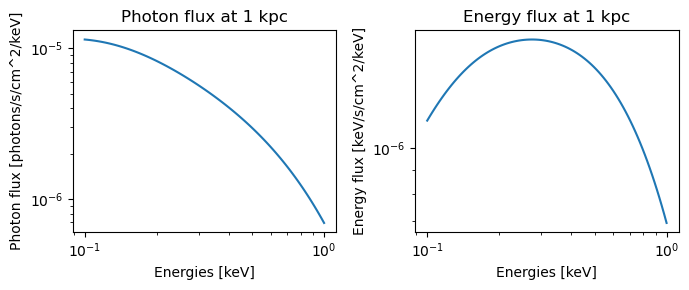

Photons per second per cm^2: 0.000573


In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(7,3))

ax[0].loglog(energies_example, flux_example)
ax[0].set_ylabel('Photon flux [photons/s/cm^2/keV]')
ax[0].set_xlabel('Energies [keV]')
ax[0].set_title(f'Photon flux at {D} kpc')

ax[1].loglog(energies_example, flux_example*energies_example)
ax[1].set_ylabel('Energy flux [keV/s/cm^2/keV]')
ax[1].set_xlabel('Energies [keV]')
ax[1].set_title(f'Energy flux at {D} kpc')

fig.tight_layout()
plt.show()

print(f'Photons per second per cm^2: {np.sum(flux_example):.3g}')




## Simulating the flux of a neutron star along with an accretion disk

Now that we have set up the disk model, let's combine its flux with that from a neutron star. We will set up a star with some parameters based on the well studied accreting millisecond X-ray pulsar SAX J1808.4-3658. Let's start with a regular spacetime.

In [8]:
from xpsi import Spacetime
from xpsi.global_imports import gravradius

bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))      # (Earth) inclination to rotation axis

spacetime = Spacetime(bounds=bounds, values=dict(frequency=400.9752075))

Creating parameter:
    > Named "frequency" with fixed value 4.010e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


To keep this tutorial concise, we will import necessary custom classes rather than rewriting them verbatim. They were already set up for the example `TestRun_AMXP.py`, and we will import them from there. Nevertheless, we will describe and highlight notable special features of these custom classes. The first Custom class is the `CustomHotRegion_Accreting`, which provides hot regions that incorporate the Compton slab atmosphere (Bobrikova et al. 2023). This class accepts three atmosphere parameters: $t_\rm{bb}$, $\tau$, $t_\rm{e}$. For this purpose the class function `_HotRegion__compute_cellParamVecs` is overwritten to accept three parameters instead of the standard two for rotation powered millisecond pulsars.

Here we will use just one circular hot spot so we only have a primary. 

In [9]:
import os
import sys
from pathlib import Path

# Get the directory of the current notebook
this_directory = str(Path().resolve())  # Resolves to the current working directory
sys.path.append(this_directory + '/../../examples/examples_modeling_tutorial/modules/') 

from CustomHotRegion_Accreting import CustomHotRegion_Accreting


bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (0.0, 0.1),
              super_tbb = (0.001, 0.003),
              super_tau = (0.5, 3.5),
              super_te = (40.0, 200.0))

primary = CustomHotRegion_Accreting(bounds=bounds,
                                    values={},
                                    symmetry=True,
                                    omit=False,
                                    cede=False,
                                    concentric=False,
                                    sqrt_num_cells=50, #100
                                    min_sqrt_num_cells=10,
                                    max_sqrt_num_cells=64, #100
                                    num_leaves=30,
                                    num_rays=200,
                                    split=True,
                                    atm_ext='Num5D',
                                    image_order_limit=3,
                                    prefix='p')

from xpsi import HotRegions
hot = HotRegions((primary,))

Creating parameter:
    > Named "super_tbb" with bounds [1.000e-03, 3.000e-03].
    > tbb.
Creating parameter:
    > Named "super_te" with bounds [4.000e+01, 2.000e+02].
    > te.
Creating parameter:
    > Named "super_tau" with bounds [5.000e-01, 3.500e+00].
    > tau.
The default/given atmosphere option is ignored, since using split=True, which only works with numerical 3+2D interpolation.
Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [0.000e+00, 1.000e-01].
    > The phase of the hot region, a periodic parameter [cycles].


Before we continue with the photosphere, we must first modify the disk model slightly, such that the flux can be combined with the flux from a star. 

First we will multiply the disk flux with the distance squared in meters. This is to match the emission unit that X-PSI is expecting, which is the total photon emission rate per unit energy (keV). Later, if computing the registered counts, the combined emission (star and disk) will be divided by distance squared (in `Likelihood.py`) to recover the flux. 

We choose to make the modification in the previous function `k_disk`, which will imply this function no longer returns `k_disk`. This is convenient because the distance was one of the function arguments, so it is readily available.

In [10]:
def get_k_disk_distance_m_squared(cos_i, r_in, distance):
    """
    This function calculates the k-disk value for a given set of input parameters.
    
    Parameters
    ----------
    cos_i: The cosine inclination angle of the disk
    r_in: The inner radius of the disk in kilometers
    distance: The distance to the disk (and star) in kiloparsecs
    
    Returns
    -------
    k_disk times the distance in meters squared
    
    """

    k_disk = cos_i * (r_in / (distance / 10))**2 # in [km/ 10 kpc]^2
    
    # K_disk is cos_i*R_in^2/D^2 in (km / 10 kpc)^2.
    # (1 km / 10 kpc)^2 = 1.0502650e-35 [ cm/cm ]^2

    k_disk *= 1.0502650e-35 # now k_disk is unitless

    # multiplying k_disk by distance squared in meters to match signal units
    distance_m = 3.08567758128e19*distance
    k_disk_distance_m_squared = k_disk*distance_m**2

    return k_disk_distance_m_squared 

Since `K_disk` is a parameter which depends solely other parameters, we use a new class to automatically derive it from those parameters. To achieve this we define a new class `k_disk_derive` which is a subclass of `xpsi.Derive`. By using the Derive functionality in X-PSI, we ensure the derived parameter is compatible with parameter sampling. 

In [11]:
class k_disk_derive(Derive):
    def __init__(self):
        pass

    def __call__(self, boundto, caller=None):
        # Ensure that self.star and self.disk are defined when we 
        # call an instance of this class. This ensures parameter 
        # values are passed along correctly.
        return get_k_disk_distance_m_squared(
            self.star['cos_inclination'], 
            self.disk['R_in'], 
            self.star['distance']
        )


In [12]:
k_disk = k_disk_derive()
values_derive = {'T_in':T_in,'R_in':R_in,'K_disk': k_disk}
bounds_example['K_disk'] = None # we must choose `None` here for the boundaries of the derived parameter. Having any boundaries here is not allowed and could cause conflicts.
disk = Disk(bounds=bounds_example, values=values_derive)

Creating parameter:
    > Named "T_in" with bounds [3.000e+00, 1.000e+01] and initial value 6.530e+00.
    > Temperature at inner disk radius in log10 Kelvin.
Creating parameter:
    > Named "R_in" with bounds [0.000e+00, 1.000e+03] and initial value 5.500e+01.
    > Disk R_in in kilometers.
Creating parameter:
    > Named "K_disk" that is derived from ulterior variables.
    > Disk normalisation cos_i*R_in^2/D^2.


Now we are ready to create instantiate the custom photosphere. This photosphere accepts a new parameter in the `init` called `disk`, and then creates a private property called `_disk`. To `disk` we will pass the instance of the disk class. The spectrum of the disk will be added to the first time-invariant component of the signal (in this case the only component since we only have one hotspot) like so:

```
# add time-invariant component to first time-dependent component
if self._disk is not None:
    self.disk_spectrum = self._disk(energies)
    for i in range(self._signal[0][0].shape[1]):
    self._signal[0][0][:,i] += self.disk_spectrum
```
The time-dependent component here has some amount of phase bins (num_leaves) and we add up the disk emission to each component. There is no need to divide the disk emission by the number of phase bins here, which one may think of doing when distributing an emission component along some number of bins such that when summing back later together one conserves the full contribution one started with. The reason why is that the signal will make use of `gsl_interp_eval_integ` (in `synthesise.pyx`) when recording data of photon counts (per second). That function already accounts for phase intervals correctly in the sense that a constant signal with any number of phase bins will integrate up correctly within in phase interval [0,1] to the number one started with. If in any other situation one may be adding a constant component with some count rate to the time dependent count rate of a star (such as by considering it a `background`), one must take care to ensure that the distribution of counts over phase bins is correct.

Another note is that we insert the disk into the `custom` argument of `xpsi.Photosphere` when calling the `super` function, which will make X-PSI aware of the disk parameters. One could add more components there in the future since custom can be a list of instances.

In [13]:
from CustomPhotosphere import CustomPhotosphere_NumA5
from xpsi import Star

photosphere = CustomPhotosphere_NumA5(hot = hot, elsewhere = None, stokes=False, disk=disk, bounds=None,
                                values=dict(mode_frequency = spacetime['frequency']))

photosphere.hot_atmosphere = this_directory+'/../../examples/examples_modeling_tutorial'+'/model_data/Bobrikova_compton_slab_I.npz'

star = Star(spacetime = spacetime, photospheres = photosphere)

Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].
Creating parameter:
    > Named "mode_frequency" with fixed value 4.010e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


Now that we have created the star instance, we can also connect the star (and the disk) to the derived `k_disk`

In [14]:
k_disk.star = star
k_disk.disk = disk

Now, we can make a SAX J1808-like parameter vector.

In [15]:
import math

# Star parameters
mass = 1.4
radius = 11.0
distance = 2.7
inclination = 80.
cos_i = math.cos(inclination*math.pi/180.0)

# Hotspot
phase_shift = 0.226365126031355196E+00
super_colatitude = 0.175993450466385537E+00
super_radius = 30.*math.pi/180

# Compton slab model parameters
tbb=0.0025
te=100.
tau=2.0

#Tbb = 1 keV <=> tbb = 0.002 (roughly)
#Te = 50 keV <=>  te = 100 (roughly)

p = [mass, #grav mass
     radius, #coordinate equatorial radius
     distance, # earth distance kpc
     cos_i, #cosine of earth inclination
     phase_shift, #phase of hotregion
     super_colatitude, #colatitude of centre of superseding region
     super_radius,  #angular radius superceding region
     tbb,
     te,
     tau,
     T_in,
     R_in,
    ]

star(p)
star.update()

We use `photosphere.integrate()`, to get the incident signal before interstellar absorption or interaction with the telescope.

In [16]:
energies = np.logspace(np.log10(0.15), np.log10(12.0), 40, base=10.0)
photosphere.integrate(energies, threads=1)
StokesI = photosphere.signal[0][0]
phases = np.linspace(0,1,30)

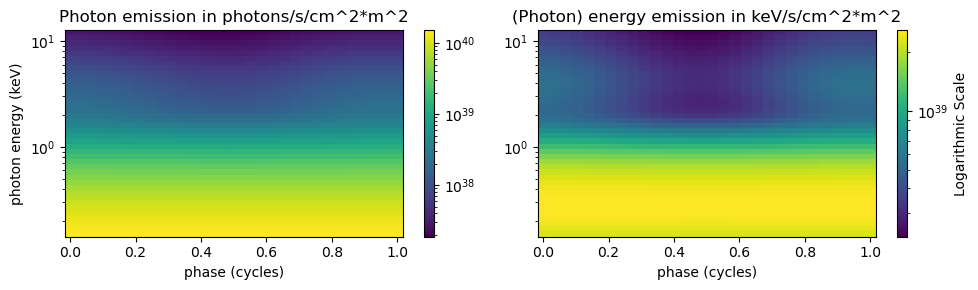

In [17]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

profile = ax[0].pcolormesh(phases, energies, StokesI, shading='auto', 
                           norm=LogNorm(vmin=StokesI.min(), vmax=StokesI.max()))
ax[0].set_yscale('log')
ax[0].set_title('Photon emission in photons/s/cm^2*m^2') # the meters squared is related to the distance to recover flux, the centimeters squared is for the instrumental effective area
ax[0].set_ylabel('photon energy (keV)')
ax[0].set_xlabel('phase (cycles)')
fig.colorbar(profile, ax=ax[0])

profile = ax[1].pcolormesh(phases, energies, (energies * StokesI.T).T, shading='auto', 
                           norm=LogNorm(vmin=(energies * StokesI.T).T.min(), 
                                        vmax=(energies * StokesI.T).T.max()))
ax[1].set_yscale('log')
ax[1].set_title('(Photon) energy emission in keV/s/cm^2*m^2')
ax[1].set_xlabel('phase (cycles)')
fig.colorbar(profile, ax=ax[1], label="Logarithmic Scale")

plt.tight_layout()
plt.show()

For completeness, here is also the 1D spectrum separately. The star flux is averaged over phase.

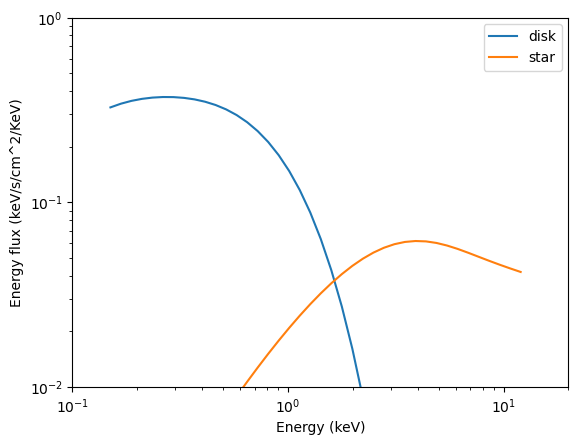

In [18]:
disk_flux_dist_sq = photosphere.disk_spectrum #m^2*photons/s/cm^2/keV
star_flux_dist_sq = np.mean(photosphere.signal[0][0],axis=1)-disk_flux_dist_sq #subtracting disk from the total to retrieve star flux

def unit_convert(F, distance):
    # assuming the distance is in 10 kpc units, which we use to convert flux to photons/s/cm^2/keV,  3.08e19 is to convert kpc to meter
    F_converted = F/(3.08567758128e19*distance)**2
    return F_converted

disk_flux = unit_convert(disk_flux_dist_sq, spacetime['distance'])
star_flux = unit_convert(star_flux_dist_sq, spacetime['distance'])

fig,ax = plt.subplots()

ax.loglog(energies, energies*disk_flux, label='disk')
ax.loglog(energies, energies*star_flux, label='star')
ax.set_xlim([0.1,20])
ax.set_ylim([1e-2, 1e0])
ax.set_ylabel('Energy flux (keV/s/cm^2/KeV)')
ax.set_xlabel('Energy (keV)')
ax.legend()

plt.show()